In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# %rm -rf "data/data_mod"
! cp -R /content/drive/MyDrive/Colonic_Crypt_Segmentation /content/

In [2]:
!pwd
import os
os.chdir('/content/Colonic_Crypt_Segmentation/')

/content


# installing required packages

In [5]:
!pip install segmentation_models_pytorch
!pip install monai
!pip install albumentations==1.1.0
!pip install tifffile
!pip uninstall opencv-python-headless
!pip install opencv-python==4.5.5.64
!pip install opencv-python-headless==4.5.5.64
!pip list |findstr opencv
!pip install 'monai[all]'
!pip install empatches
!pip install segmentation-mask-overlay

     |████████████████████████████████| 88 kB 3.9 MB/s 
     |████████████████████████████████| 376 kB 29.4 MB/s 
     |████████████████████████████████| 58 kB 6.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=2835e6dedf29e7adfcc9a80e5589189439e02458d3950691171304b99f99b7a5
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=9b882229fc3a89a4042847207bfcdc78f3f884f66cc944a455e73faa18fce5d1
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
     |████████████████████████████████| 721 kB 5.1 MB/s 
     |████████████████████████████████| 102 kB 6.6 MB/s 
     |████████████████████████████████| 47.8 MB 1.3 MB/s 
  Attempting uninstall: albumentations


In [57]:
import trainer
import model_config
import numpy as np
import dataset
import datapreprocessing as dapre
import dataset as dal
from torch.utils.data import DataLoader,Dataset
import torch
from monai.networks.nets import UNet
import monai
from monai.networks.nets import UNETR
from monai.losses import DiceLoss, DiceCELoss
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import pandas as pd



In [ ]:
traindt=dataset.TissueData(dapre.TRAIN_IMGPATCH_SAVEPATH,dapre.TRAIN_MASKPATCH_SAVEPATH,dataset.TRAIN_TRANSFORMS)
testdt=dataset.TissueData(dapre.TEST_IMGPATCH_SAVEPATH,dapre.TEST_MASKPATCH_SAVEPATH,dataset.TEST_TRANSFORMS)


In [ ]:
trainloader=DataLoader(traindt,batch_size=12,shuffle=True)
testloader=DataLoader(testdt,batch_size=12,shuffle=False)

In [ ]:
model_list = {'UNETR':UNETR(spatial_dims=2,
            img_size=512,
            in_channels=3,
            out_channels=1,
            feature_size=16, 
            num_heads=6,
            dropout_rate=0.2,
            hidden_size=384,
            mlp_dim=768,
            norm_name='batch'
            ),
            'UNET_EFFb2':smp.Unet(encoder_name='efficientnet-b2',in_channels=3,classes=1,
            encoder_weights='imagenet'),
            'UNETplusplus_EFFb2':smp.UnetPlusPlus(encoder_name='efficientnet-b2',in_channels=3,classes=1,
            encoder_weights='imagenet'),
            'DEEPLABV3_xception':smp.DeepLabV3Plus(encoder_name='tu-xception41',in_channels=3,classes=1,encoder_output_stride=16,
            encoder_weights='imagenet')}



# UNET with Efficientnetb2 backbone

In [ ]:
md=model_config.modelconf(MODEL=model_list['UNET_EFFb2'],preproc=get_preprocessing_fn('efficientnet-b2', pretrained='imagenet'))
modeltrainer=trainer.model_trainer(conf=md,trainloader=trainloader,testloader=testloader)


In [ ]:
modeltrainer.fit()

epoch 1/20
epoch 1 average loss: 0.7438


/usr/local/lib/python3.7/dist-packages/monai/transforms/post/array.py:182: UserWarning: `threshold_values=True/False` is deprecated, please use `threshold=value` instead.
  warnings.warn("`threshold_values=True/False` is deprecated, please use `threshold=value` instead.")


current epoch: 1 Avg test Dice: 0.0389 Avg test loss: 0.9368
saved new best metric model
epoch 2/20
epoch 2 average loss: 0.6303
current epoch: 2 Avg test Dice: 0.0186 Avg test loss: 0.9276
epoch 3/20
epoch 3 average loss: 0.5352
current epoch: 3 Avg test Dice: 0.1847 Avg test loss: 0.7270
saved new best metric model
epoch 4/20
epoch 4 average loss: 0.4752
current epoch: 4 Avg test Dice: 0.6629 Avg test loss: 0.4227
saved new best metric model
epoch 5/20
epoch 5 average loss: 0.4387
current epoch: 5 Avg test Dice: 0.8213 Avg test loss: 0.2928
saved new best metric model
epoch 6/20
epoch 6 average loss: 0.4071
current epoch: 6 Avg test Dice: 0.8487 Avg test loss: 0.2451
saved new best metric model
epoch 7/20
epoch 7 average loss: 0.3873
current epoch: 7 Avg test Dice: 0.8488 Avg test loss: 0.2356
saved new best metric model
epoch 8/20
epoch 8 average loss: 0.3580
current epoch: 8 Avg test Dice: 0.8412 Avg test loss: 0.2210
epoch 9/20
epoch 9 average loss: 0.3411
current epoch: 9 Avg tes

##  UNET train loss(DiceCELoss): 0.2224, Best Avg test Dice: 0.8732 Avg test loss: 0.1524

# UNETR transformer based model

In [ ]:
trainloader=DataLoader(traindt,batch_size=6,shuffle=True)
testloader=DataLoader(testdt,batch_size=6,shuffle=False)
md=model_config.modelconf(MODEL=model_list['UNETR'],preproc=None)
modeltrainer=trainer.model_trainer(conf=md,trainloader=trainloader,testloader=testloader)

In [ ]:
pytorch_total_params = sum(p.numel() for p in md.MODEL.parameters())/1000000
pytorch_total_params #Model parameters in millions

16.243441

### Note smaller batchsize of 6 due to large number of parameterss (16.2 M)

In [ ]:
modeltrainer.fit()

epoch 1/20
epoch 1 average loss: 0.7431


`threshold_values=True/False` is deprecated, please use `threshold=value` instead.


current epoch: 1 Avg test Dice: 0.3603 Avg test loss: 0.6510
saved new best metric model
epoch 2/20
epoch 2 average loss: 0.7160
current epoch: 2 Avg test Dice: 0.4253 Avg test loss: 0.6145
saved new best metric model
epoch 3/20
epoch 3 average loss: 0.7106
current epoch: 3 Avg test Dice: 0.4245 Avg test loss: 0.6019
epoch 4/20
epoch 4 average loss: 0.7016
current epoch: 4 Avg test Dice: 0.4207 Avg test loss: 0.5991
epoch 5/20
epoch 5 average loss: 0.7035
current epoch: 5 Avg test Dice: 0.4343 Avg test loss: 0.5837
saved new best metric model
epoch 6/20
epoch 6 average loss: 0.6945
current epoch: 6 Avg test Dice: 0.4218 Avg test loss: 0.5884
epoch 7/20
epoch 7 average loss: 0.6893
current epoch: 7 Avg test Dice: 0.2972 Avg test loss: 0.6986
epoch 8/20
epoch 8 average loss: 0.6886
current epoch: 8 Avg test Dice: 0.4413 Avg test loss: 0.5597
saved new best metric model
epoch 9/20
epoch 9 average loss: 0.6894
current epoch: 9 Avg test Dice: 0.3554 Avg test loss: 0.6392
epoch 10/20
epoch 1

##  UNETR: train loss(DiceCELoss): 0.6619, Best Avg test Dice: 0.5130 Avg test loss: 0.5011

### model does not converge in 20 epochs (noisy training) due to smaller batch size


In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Thu Apr 21 03:12:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# UNET++ with Efficientnetb2 backbone

In [ ]:
trainloader=DataLoader(traindt,batch_size=12,shuffle=True)
testloader=DataLoader(testdt,batch_size=12,shuffle=False)
md=model_config.modelconf(MODEL=model_list['UNETplusplus_EFFb2'],preproc=get_preprocessing_fn('efficientnet-b2', pretrained='imagenet'))
modeltrainer=trainer.model_trainer(conf=md,trainloader=trainloader,testloader=testloader)

In [ ]:
pytorch_total_params = sum(p.numel() for p in md.MODEL.parameters())/1000000
pytorch_total_params #Model parameters in millions

10.401299

In [ ]:
modeltrainer.fit()

epoch 1/20
epoch 1 average loss: 0.7509


`threshold_values=True/False` is deprecated, please use `threshold=value` instead.


current epoch: 1 Avg test Dice: 0.0239 Avg test loss: 0.9609
saved new best metric model
epoch 2/20
epoch 2 average loss: 0.6018
current epoch: 2 Avg test Dice: 0.0803 Avg test loss: 0.8008
saved new best metric model
epoch 3/20
epoch 3 average loss: 0.5036
current epoch: 3 Avg test Dice: 0.2199 Avg test loss: 0.7110
saved new best metric model
epoch 4/20
epoch 4 average loss: 0.4467
current epoch: 4 Avg test Dice: 0.6674 Avg test loss: 0.4263
saved new best metric model
epoch 5/20
epoch 5 average loss: 0.4086
current epoch: 5 Avg test Dice: 0.8223 Avg test loss: 0.3051
saved new best metric model
epoch 6/20
epoch 6 average loss: 0.3752
current epoch: 6 Avg test Dice: 0.8512 Avg test loss: 0.2492
saved new best metric model
epoch 7/20
epoch 7 average loss: 0.3449
current epoch: 7 Avg test Dice: 0.8647 Avg test loss: 0.2212
saved new best metric model
epoch 8/20
epoch 8 average loss: 0.3246
current epoch: 8 Avg test Dice: 0.8689 Avg test loss: 0.2042
saved new best metric model
epoch 9/

In [ ]:
#training UNET++ for 5 more epochs
modeltrainer.EPOCHS=5

In [ ]:
modeltrainer.fit()

epoch 1/5
epoch 1 average loss: 0.1971


`threshold_values=True/False` is deprecated, please use `threshold=value` instead.


current epoch: 1 Avg test Dice: 0.8534 Avg test loss: 0.1552
saved new best metric model
epoch 2/5
epoch 2 average loss: 0.2026
current epoch: 2 Avg test Dice: 0.8611 Avg test loss: 0.1482
saved new best metric model
epoch 3/5
epoch 3 average loss: 0.1731
current epoch: 3 Avg test Dice: 0.8442 Avg test loss: 0.1640
epoch 4/5
epoch 4 average loss: 0.1880
current epoch: 4 Avg test Dice: 0.8660 Avg test loss: 0.1422
saved new best metric model
epoch 5/5
epoch 5 average loss: 0.1919
current epoch: 5 Avg test Dice: 0.8646 Avg test loss: 0.1415


##  UNET++: train loss(DiceCELoss): 0.1880, Best Avg test Dice: 0.8660 Avg test loss: 0.1422

# DeepLabv3++ with xception41 backbone

In [ ]:
trainloader=DataLoader(traindt,batch_size=12,shuffle=True)
testloader=DataLoader(testdt,batch_size=12,shuffle=False)
md=model_config.modelconf(MODEL=model_list['DEEPLABV3_xception'],preproc=get_preprocessing_fn('efficientnet-b2', pretrained='imagenet'))
modeltrainer=trainer.model_trainer(conf=md,trainloader=trainloader,testloader=testloader)

In [ ]:
pytorch_total_params = sum(p.numel() for p in md.MODEL.parameters())/1000000
pytorch_total_params #Model parameters in millions

28.090113

In [ ]:
modeltrainer.fit()

epoch 1/20
epoch 1 average loss: 0.6651


`threshold_values=True/False` is deprecated, please use `threshold=value` instead.


current epoch: 1 Avg test Dice: 0.6836 Avg test loss: 0.4330
saved new best metric model
epoch 2/20
epoch 2 average loss: 0.4846
current epoch: 2 Avg test Dice: 0.7064 Avg test loss: 0.3627
saved new best metric model
epoch 3/20
epoch 3 average loss: 0.4234
current epoch: 3 Avg test Dice: 0.7354 Avg test loss: 0.3249
saved new best metric model
epoch 4/20
epoch 4 average loss: 0.3703
current epoch: 4 Avg test Dice: 0.7917 Avg test loss: 0.2564
saved new best metric model
epoch 5/20
epoch 5 average loss: 0.3460
current epoch: 5 Avg test Dice: 0.8100 Avg test loss: 0.2458
saved new best metric model
epoch 6/20
epoch 6 average loss: 0.3209
current epoch: 6 Avg test Dice: 0.8382 Avg test loss: 0.1965
saved new best metric model
epoch 7/20
epoch 7 average loss: 0.3059
current epoch: 7 Avg test Dice: 0.8322 Avg test loss: 0.2090
epoch 8/20
epoch 8 average loss: 0.2816
current epoch: 8 Avg test Dice: 0.8388 Avg test loss: 0.2011
saved new best metric model
epoch 9/20
epoch 9 average loss: 0.2

##  DeepLabv3++: train loss(DiceCELoss): 0.1809, Best Avg test Dice: 0.8671 Avg test loss: 0.1416

In [ ]:
# Predictions

In [4]:
import predict
import datapreprocessing as dapre
import tifffile
import dataset
from albumentations.pytorch.transforms import ToTensorV2
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose
)
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import numpy as np
from empatches import EMPatches


In [5]:
# modlist=predict.load_models("modelsaved/",['UNET','UNET++','DeepLab',])
modlist=predict.load_models("modelsaved/",['UNET++','DeepLab',])


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_xception_41-e6439c97.pth" to /root/.cache/torch/hub/checkpoints/tf_xception_41-e6439c97.pth


# Model prediction comparision with ground truth

<tifffile.TiffFile 'CL_HandE_1234_B0…bottomleft.tiff'> shaped series axes do not match shape


CL_HandE_1234_B004_bottomleft.tiff


<tifffile.TiffFile 'HandE_B005_CL_b…_bottomleft.tiff'> shaped series axes do not match shape


HandE_B005_CL_b_RGB_bottomleft.tiff


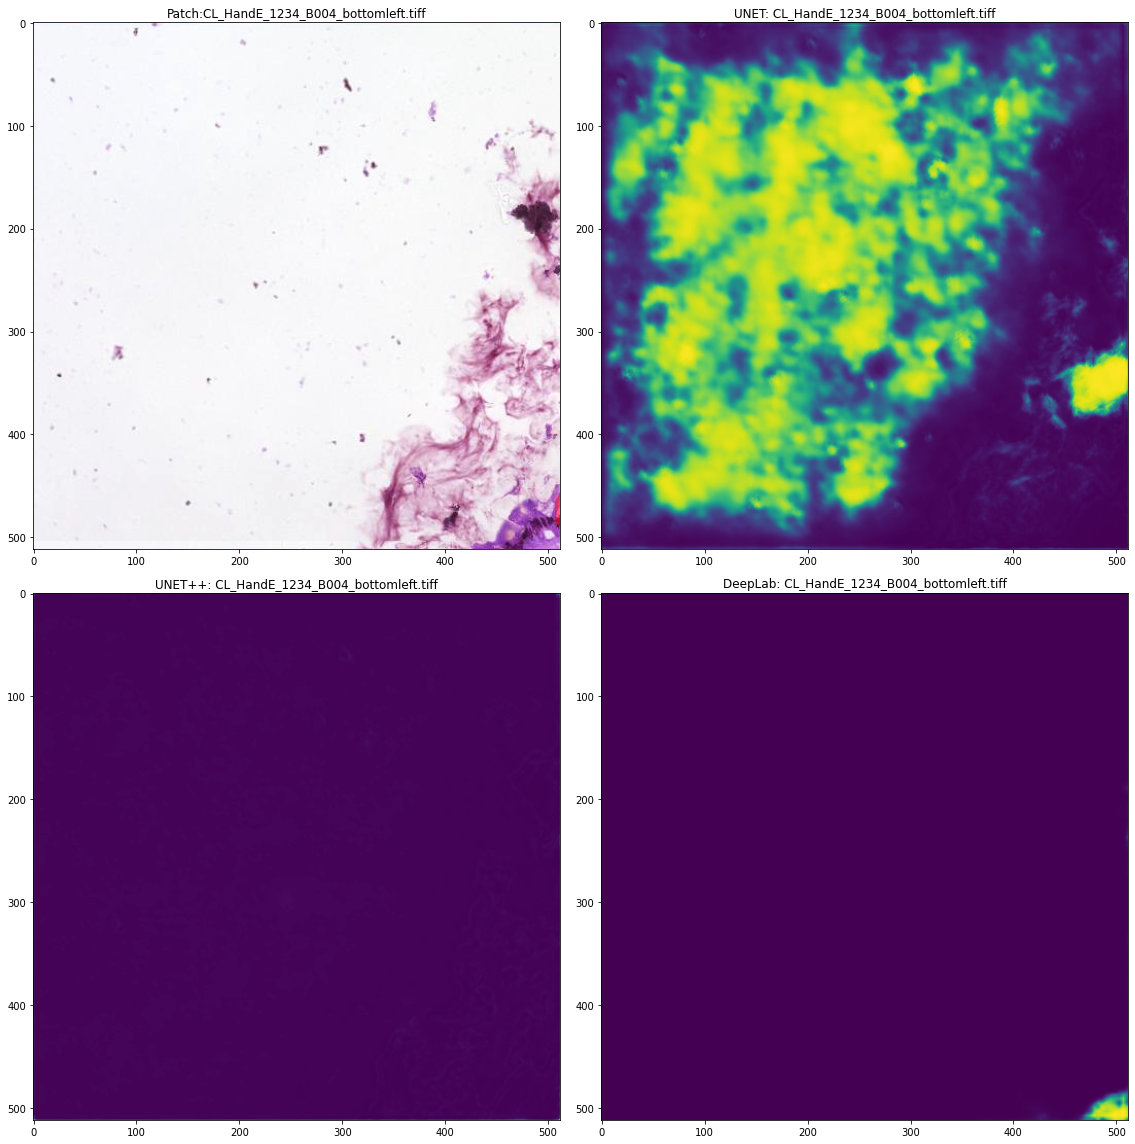

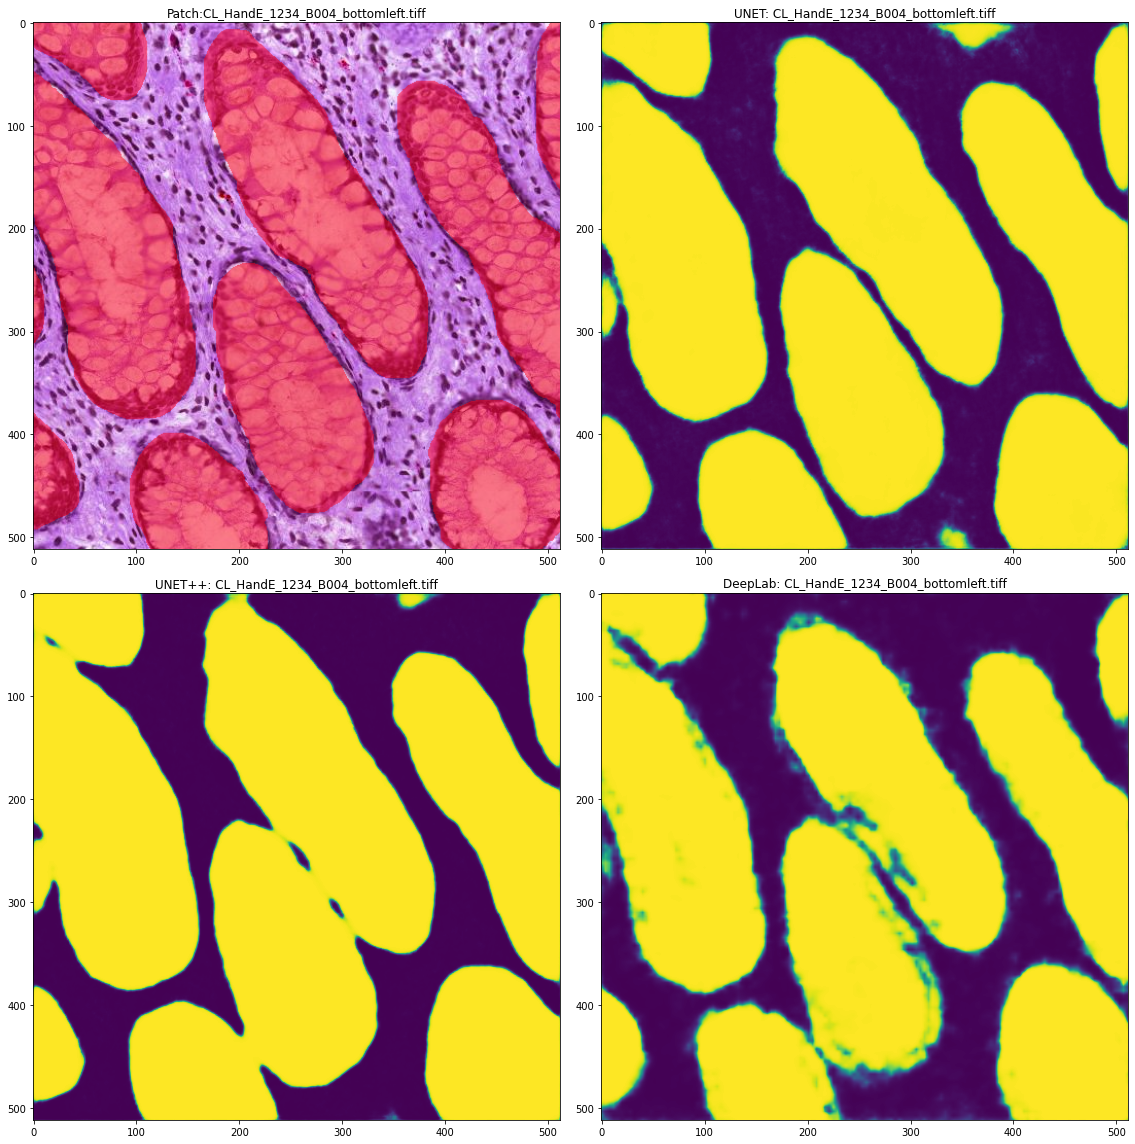

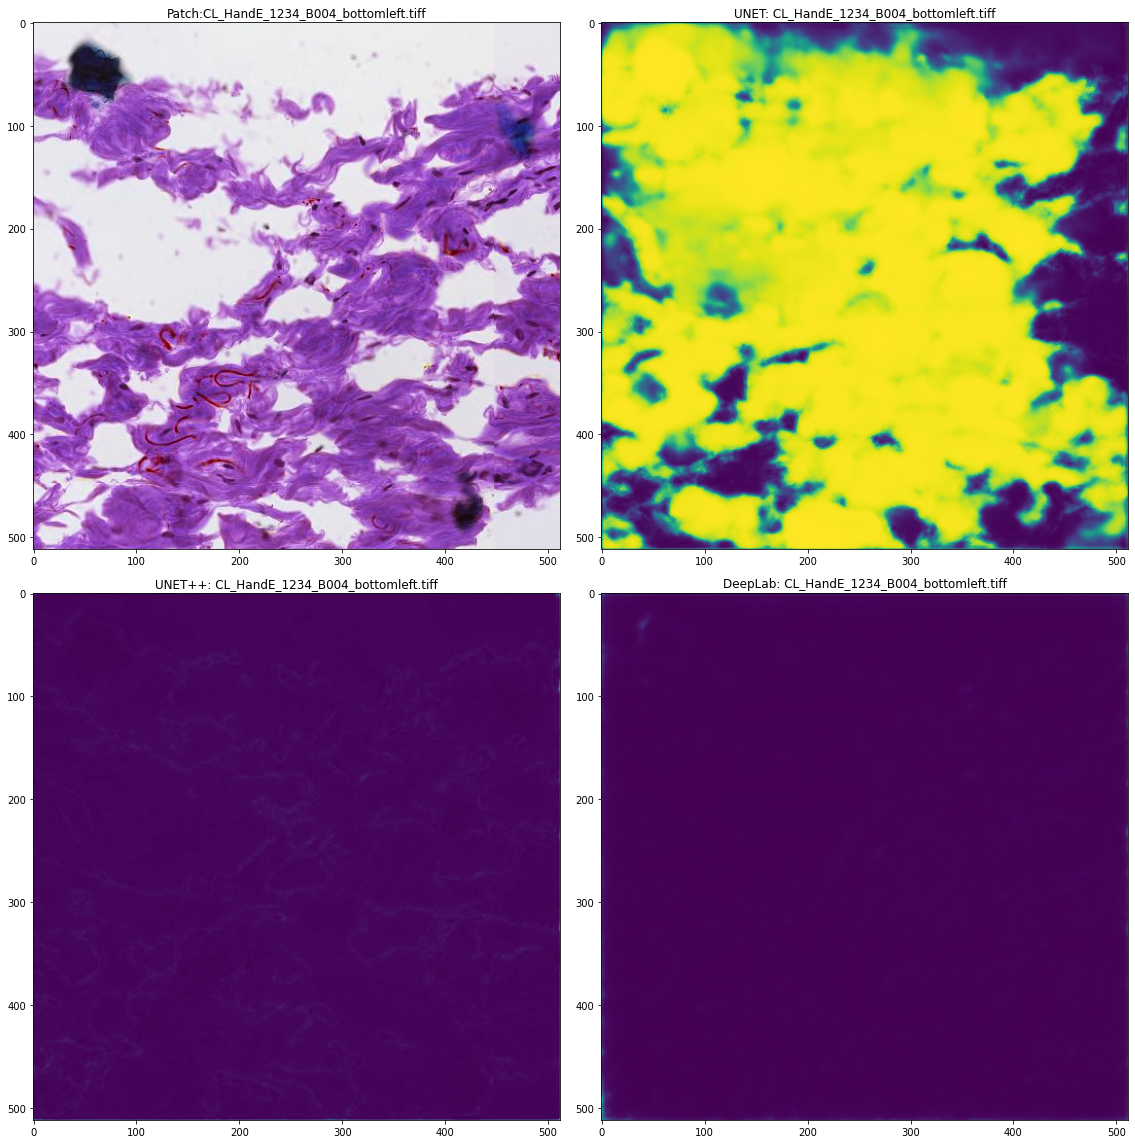

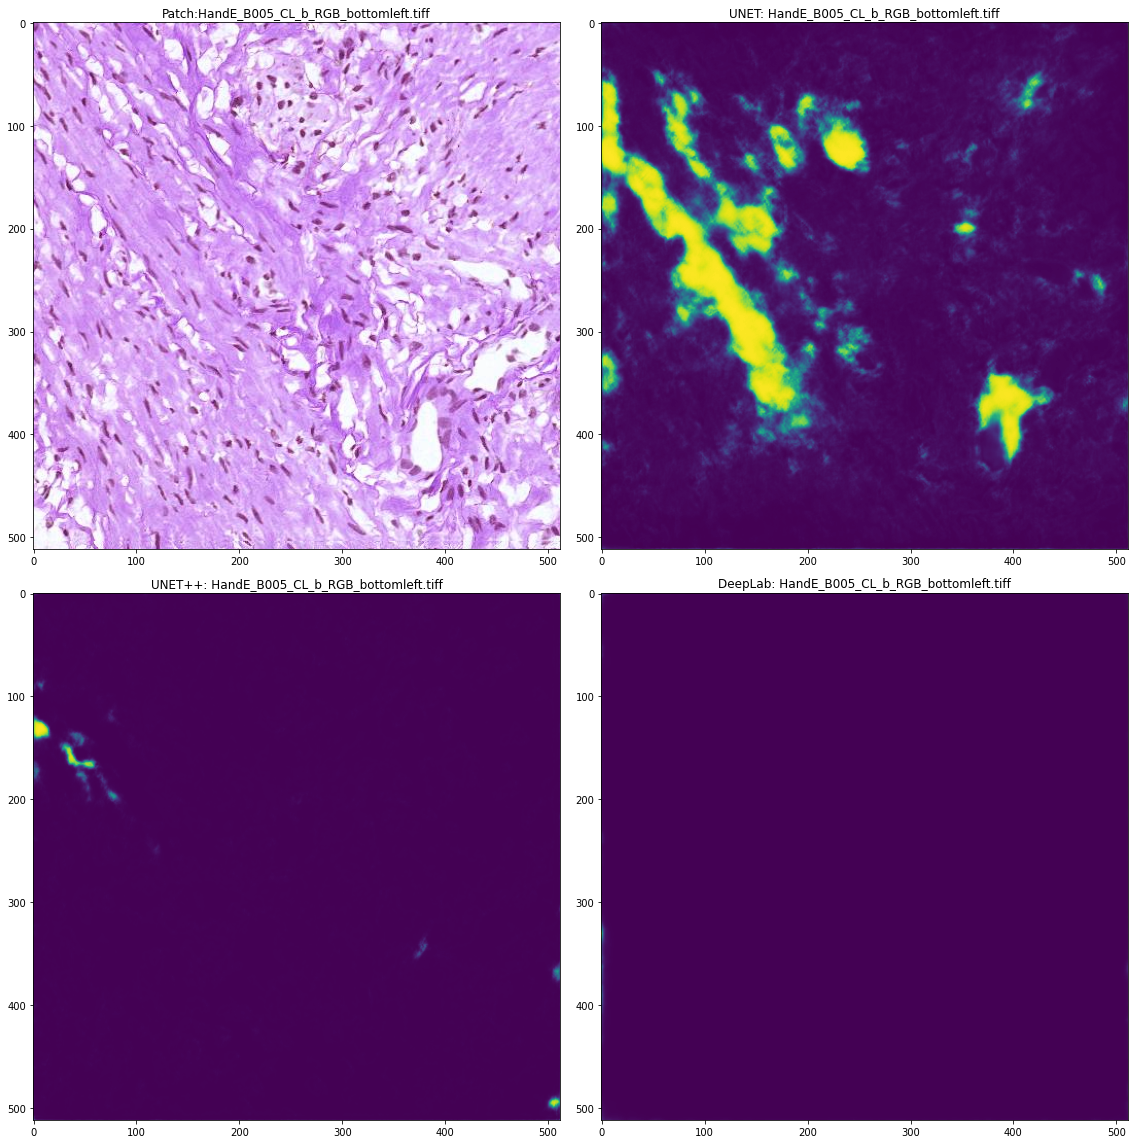

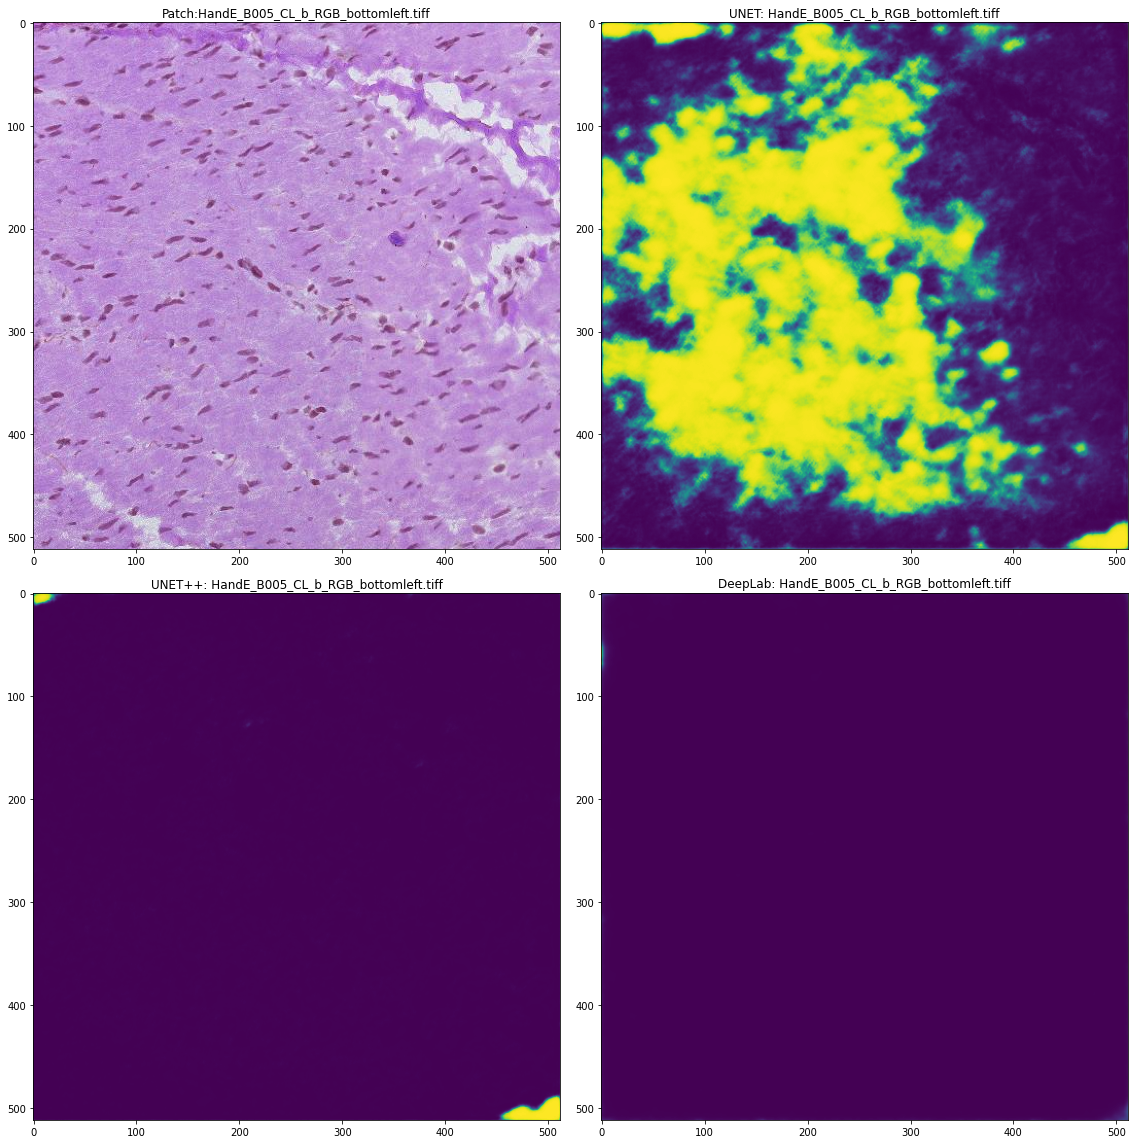

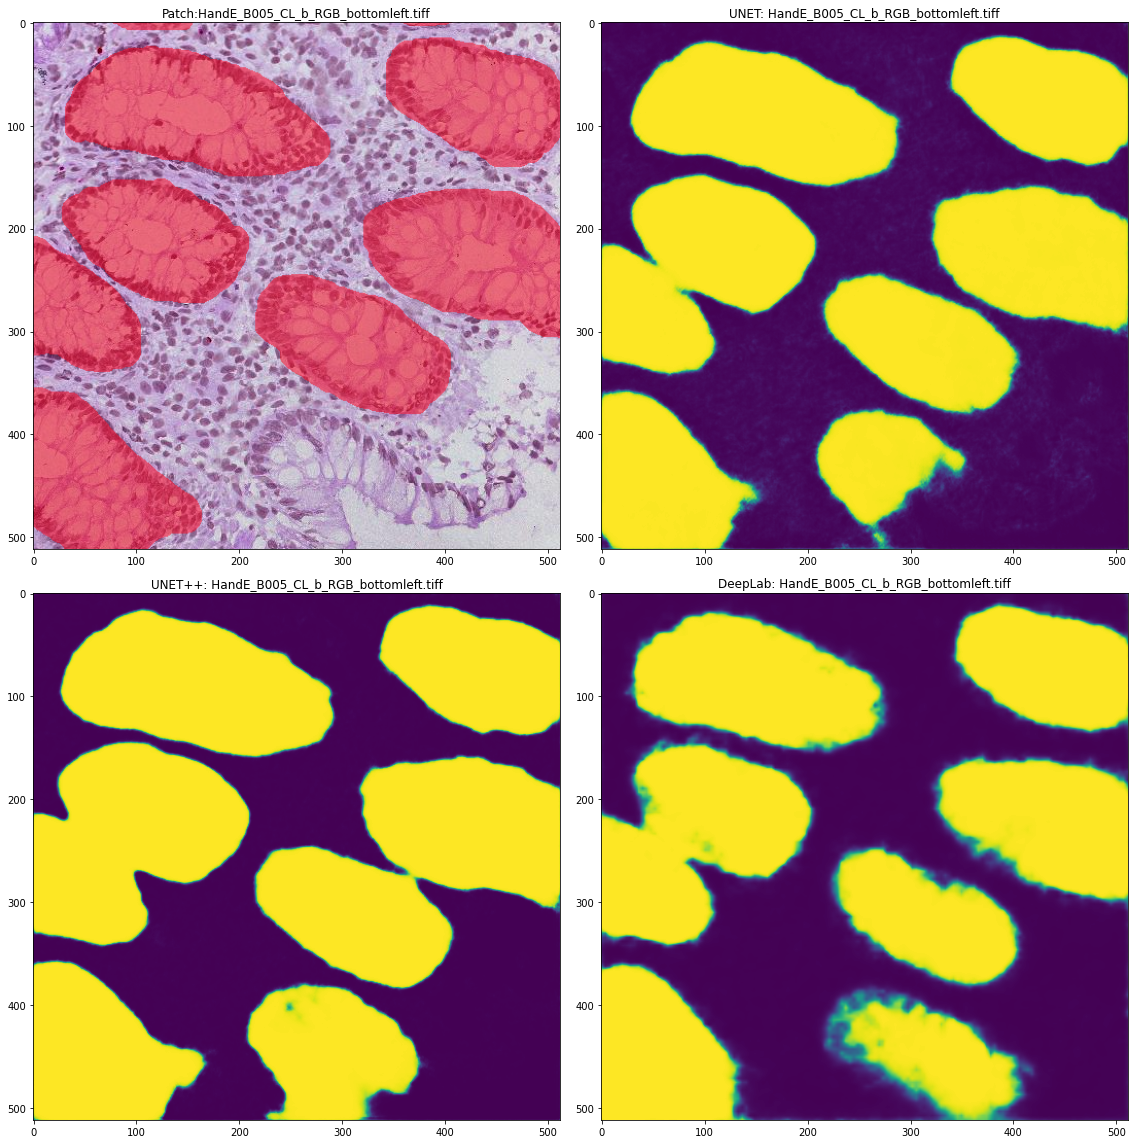

In [ ]:
patchpred=predict.predictPatchlist(dapre.TEST_PATH_ORIG,modlist)

# Final Test Mask predictions using Average predictions of : {UNET++,DeepLabv3++}

In [ ]:
# from segmentation_mask_overlay import overlay_masks
from monai.visualize.utils import blend_images

<tifffile.TiffFile 'CL_HandE_1234_B0…bottomleft.tiff'> shaped series axes do not match shape
<tifffile.TiffFile 'HandE_B005_CL_b…_bottomleft.tiff'> shaped series axes do not match shape


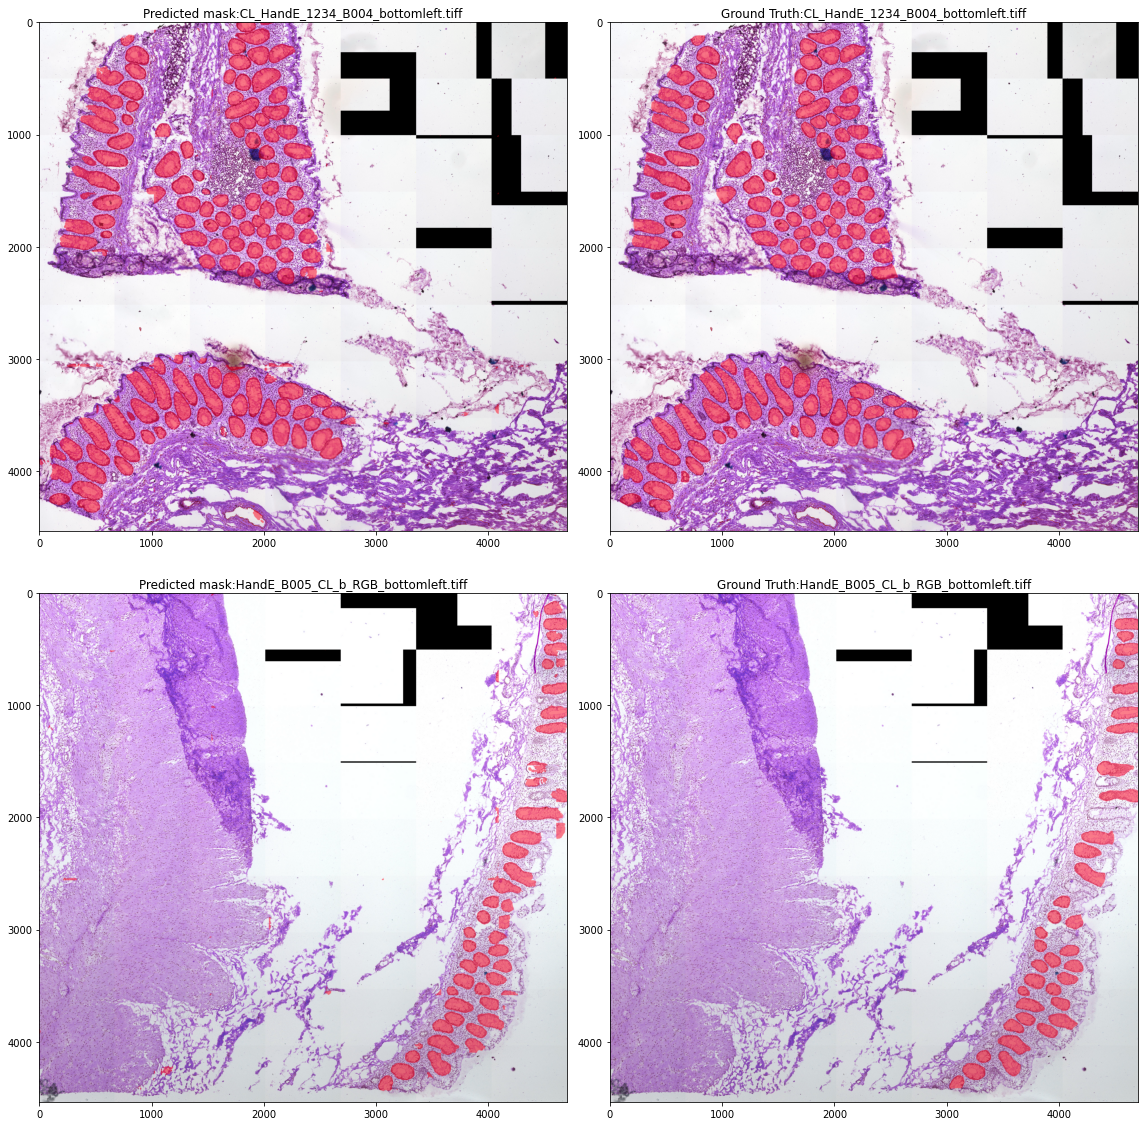

In [ ]:
fig=plt.figure(figsize=(16, 16))
rows = 2
cols = 2
axes=[]
a=0
for i in os.listdir(dapre.TEST_PATH_ORIG):
    if ".tiff" not in i:
          continue
    image = tifffile.imread(dapre.TEST_PATH_ORIG+i)
    mask =tifffile.imread("predictedtestMask/"+i)
    maskA = tifffile.imread(dapre.TESTMASK_ORIG+i)
    mask=mask[:,:,1]
    mask=dataset.TEST_TRANSFORMS(image=mask)['image']
    # maskA=maskA
    maskA=dataset.TEST_TRANSFORMS(image=maskA)['image']
    image=dataset.TEST_TRANSFORMS(image=image)['image']
    # print(mask.shape)
    bi=blend_images(image,label=mask,alpha=0.5)
    biA=blend_images(image,label=maskA,alpha=0.5)
    bi=bi.permute(1,2,0)
    axes.append(fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Predicted mask:"+i)
    axes[-1].set_title(subplot_title)  
    plt.imshow(bi)
    a+=1
    biA=biA.permute(1,2,0)
    axes.append(fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Ground Truth:"+i)
    axes[-1].set_title(subplot_title)  
    plt.imshow(biA)
    a+=1
fig.tight_layout()    
plt.show()

## Average Dice Score of Test Images
### {CL_HandE_1234_B0…bottomleft.tiff: 0.9174
### HandE_B005_CL_b…_bottomleft:0.8065}

In [46]:
maskslst=os.listdir("predictedtestMask/")
for i in maskslst:
  maskpred = image=tifffile.imread("predictedtestMask/"+i)[:,:,0]/255.
  mask=image=tifffile.imread(dapre.TESTMASK_ORIG+i)/255.
  isection =np.sum(maskpred*mask)
  union=np.sum(mask) + np.sum(maskpred)
  dice = (2.0 * isection) / (union)
  print(dice)

<tifffile.TiffFile 'CL_HandE_1234_B0…bottomleft.tiff'> shaped series axes do not match shape
<tifffile.TiffFile 'HandE_B005_CL_b…_bottomleft.tiff'> shaped series axes do not match shape


0.9174188598428187
0.8065256797583081


## RLE Encoding

In [55]:
def rle_encode(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
testdir = "predictedtestMask/"
testmaskslist = os.listdir(testdir)
df = pd.DataFrame(columns=['img', 'pixels'])
df['img'] = [i[0:len(i)-5] for i in testmaskslist]
rlelist = []
for i, msk in enumerate(testmaskslist):
    mask = tifffile.imread(testdir+msk)[:, :, 0]
    print(mask.shape)
    mask = mask/255.
    rle_msk = rle_encode(mask)
    rlelist.append(rle_msk)
    print(rle_msk)
df['pixels'] = rlelist
df.head(5)
df.to_csv("submission.csv", index=False)


# Visualization of Test and Train Overlap

In [14]:

md=modlist['UNET++']



In [29]:
testdir=dapre.TEST_PATH_ORIG
train=dapre.TRAIN_PATH_ORIG
testimglist=os.listdir(testdir)
emp = EMPatches()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
testfeaturesGlobal=[]
testlabelsGlobal=[]
for ind,ti in enumerate(testimglist):
    if ".tiff" not in ti:
          continue
    print(ti)
    ig=tifffile.imread(testdir+ti)
    igmk=tifffile.imread(dapre.TESTMASK_ORIG+ti)

    ig2=cv2.copyMakeBorder(
              ig, 
              0, 
              72, 
              0, 
              416, 
              cv2.BORDER_CONSTANT, 
              value=0
          )
    ig2mk=cv2.copyMakeBorder(
        igmk, 
        0, 
        72, 
        0, 
        416, 
        cv2.BORDER_CONSTANT, 
        value=0
    )
    patches, indices = emp.extract_patches(ig2, patchsize=512, overlap=0)
    patchesmk, indices = emp.extract_patches(ig2mk, patchsize=512, overlap=0)

    testfeatures=[]
    testlabels=[]
    for i,img in enumerate(patches):
        img=dataset.TEST_TRANSFORMS(image=img)['image']
        img=img.unsqueeze(0)
        img=img.to(device)
        patchfeat=md.encoder(img.float())[5].flatten().detach().cpu().numpy()
        mask=patchesmk[i]
        featlabel=np.max((np.array(mask,dtype=int)>0)*1)
        # print(patchfeat.shape)
        testfeatures.append(patchfeat)
        testlabels.append(featlabel)
    
    testfeaturesGlobal.extend(testfeatures)
    testlabelsGlobal.extend(testlabels)
    


<tifffile.TiffFile 'CL_HandE_1234_B0…bottomleft.tiff'> shaped series axes do not match shape


CL_HandE_1234_B004_bottomleft.tiff


<tifffile.TiffFile 'HandE_B005_CL_b…_bottomleft.tiff'> shaped series axes do not match shape


HandE_B005_CL_b_RGB_bottomleft.tiff


In [10]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# testdir=dapre.TEST_PATH_ORIG
train=dapre.TRAIN_PATH_ORIG
trainimglist=os.listdir(train)
emp = EMPatches()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainfeaturesGlobal=[]
trainlabelsGlobal=[]
for ind,ti in enumerate(trainimglist):
    if ".tiff" not in ti:
          continue
    print(ti)
    ig=tifffile.imread(train+ti)
    igmk=tifffile.imread(dapre.TRAINMASK_ORIG+ti)

    ig2=cv2.copyMakeBorder(
              ig, 
              0, 
              72, 
              0, 
              416, 
              cv2.BORDER_CONSTANT, 
              value=0
          )
    ig2mk=cv2.copyMakeBorder(
        igmk, 
        0, 
        72, 
        0, 
        416, 
        cv2.BORDER_CONSTANT, 
        value=0
    )
    patches, indices = emp.extract_patches(ig2, patchsize=512, overlap=0)
    patchesmk, indices = emp.extract_patches(ig2mk, patchsize=512, overlap=0)

    trainfeatures=[]
    trainlabels=[]
    print(device)


    for i,img in enumerate(patches):
        img=dataset.TEST_TRANSFORMS(image=img)['image']
        img=img.unsqueeze(0)
        img=img.to(device)
        patchfeat=md.encoder(img.float())[5].flatten().detach().cpu().numpy()
        mask=patchesmk[i]
        featlabel=np.max((np.array(mask,dtype=int)>0)*1)
        # print(patchfeat.shape)
        trainfeatures.append(patchfeat)
        trainlabels.append(featlabel)

    trainfeaturesGlobal.extend(trainfeatures)
    trainlabelsGlobal.extend(trainlabels)





print(len(trainfeaturesGlobal),len(trainlabelsGlobal))

<tifffile.TiffFile 'CL_HandE_1234_B…bottomright.tiff'> shaped series axes do not match shape


CL_HandE_1234_B004_bottomright.tiff
cuda


<tifffile.TiffFile 'CL_HandE_1234_B004_topleft.tiff'> shaped series axes do not match shape


CL_HandE_1234_B004_topleft.tiff
cuda


<tifffile.TiffFile 'CL_HandE_1234_B004_topright.tiff'> shaped series axes do not match shape


CL_HandE_1234_B004_topright.tiff
cuda


<tifffile.TiffFile 'HandE_B005_CL_b_…ottomright.tiff'> shaped series axes do not match shape


HandE_B005_CL_b_RGB_bottomright.tiff
cuda


<tifffile.TiffFile 'HandE_B005_CL_b_RGB_topleft.tiff'> shaped series axes do not match shape


HandE_B005_CL_b_RGB_topleft.tiff
cuda
450 450


In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [31]:
train_scaled_feat = (trainfeaturesGlobal - np.min(trainfeaturesGlobal))/ (np.max(trainfeaturesGlobal) - np.min(trainfeaturesGlobal))
test_scaled_feat = (testfeaturesGlobal - np.min(testfeaturesGlobal))/ (np.max(testfeaturesGlobal) - np.min(testfeaturesGlobal))

In [32]:
train_tsne = TSNE(verbose=1,random_state=42,perplexity=50).fit_transform(train_scaled_feat)
test_tsne =TSNE(verbose=1,random_state=42,perplexity=50).fit_transform(test_scaled_feat)

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 450 samples in 0.039s...
[t-SNE] Computed neighbors for 450 samples in 1.763s...
[t-SNE] Computed conditional probabilities for sample 450 / 450
[t-SNE] Mean sigma: 2.457355
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.472267
[t-SNE] KL divergence after 1000 iterations: 1.132570
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 180 samples in 0.015s...


The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computed neighbors for 180 samples in 0.537s...
[t-SNE] Computed conditional probabilities for sample 180 / 180
[t-SNE] Mean sigma: 3.110552
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.094780
[t-SNE] KL divergence after 1000 iterations: 0.571739


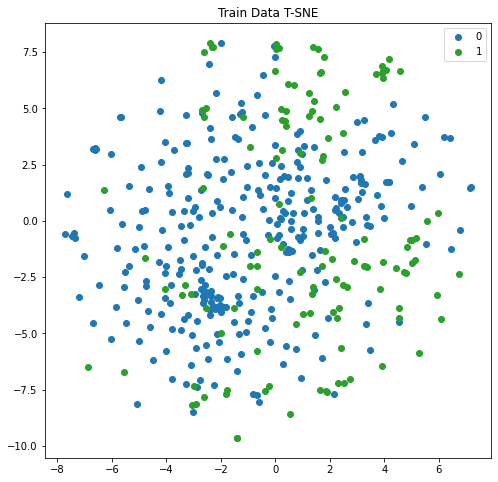

In [46]:
#reference: https://learnopencv.com/t-sne-for-feature-visualization/

tx = train_tsne[:, 0]
ty = train_tsne[:, 1]
colors_per_class=[0,255]
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title("Train Data T-SNE")
for label in [0,1]:
    indices = [i for i, l in enumerate(trainlabelsGlobal) if l == label]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    color = '#1f77b4' if colors_per_class[label]==0 else '#2ca02c'
    ax.scatter(current_tx, current_ty, c=color, label=label)
ax.legend(loc='best')
plt.savefig('report_images/'+"train_tsne"+'_'+'.png')
plt.show()

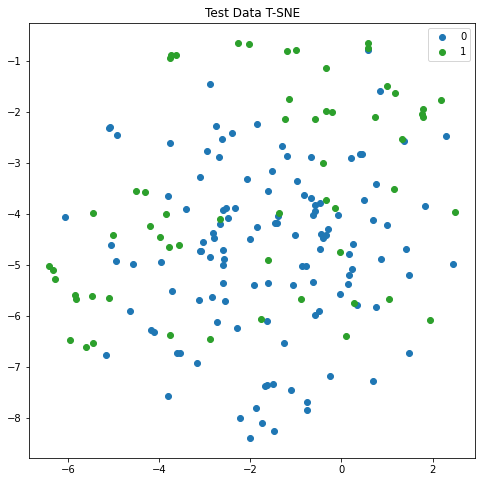

In [47]:
tx = test_tsne[:, 0]
ty = test_tsne[:, 1]
colors_per_class=[0,255]
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title("Test Data T-SNE")
for label in [0,1]:
    indices = [i for i, l in enumerate(testlabelsGlobal) if l == label]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    color = '#1f77b4' if colors_per_class[label]==0 else '#2ca02c'
    ax.scatter(current_tx, current_ty, c=color, label=label)
ax.legend(loc='best')
plt.savefig('report_images/'+"test_tsne"+'_'+'.png')
plt.show()